# Model Example
This notebook provides an example for how to setup a model and obtain the 3d intensity.

## Setup
1. Define ray parameters, such as distribution type and number of rays.
2. Define propagation grid parameters, such as wavelength and grid spacing.
3. Create lens object to model. 

In [1]:
import numpy as np
import model_tools.raytrace as rt
import model_tools.propagation as pt
import matplotlib.pyplot as plt
from pathlib import Path
import time

root_dir = Path(r"/home/sjshepp2/Documents/github/SPIM_model/data")
save_dir = rt.get_unique_dir(root_dir, "example_model_results")
showfig= True

# Define ray parameters.
rays_params = {"type":"gaussian",
               "source":"infinity",
               "n_rays":5e6,
               "diameter":8,
               "sampling_limit":3
               }

# Propagation constants
wl = 0.000561
ko = 2 * np.pi / wl
x_max = 0.400
x_padding = 0.050
z_max = 0.400

dz = 0.005
dx = wl/2
n_xy = int(x_max // dx)
n_zx = int(z_max // dz)

# enforce odd grid numbers
if n_xy%2 == 0:
    n_xy += 1
if n_zx%2 == 0:
    n_zx += 1

# Create 3d grid for field propagation.
focus_field_params = pt.field_grid(num_xy=n_xy,
                                   num_zx=n_zx,
                                   dx=dx,
                                   dz=dz,
                                   return_field=False
                                   )
x, radius_xy, extent_xy, z, extent_zx = focus_field_params

# create 2d grid for interpolation.
initial_field_params = pt.field_grid(num_xy=n_xy,
                                     num_zx=1,
                                     dx=50/n_xy,
                                     dz=dz,
                                     return_field=False
                                     )

x_i, radius_xy_i = initial_field_params[0:2]

# Create lens to model
ac508_150_a1 = rt.Doublet_lens(z1=155,
                              r1=83.2,
                              t1=12.0,
                              ri1=1.5214,
                              r2=-72.1,
                              t2=3.0,
                              ri2=1.6848,
                              r3=-247.7,
                              aperture_radius=(50.8/2),
                              ri_in=1.0, ri_out=1.0)
ac508_150_a1.label="ac508-150-A"

ac508_150_a2 = rt.Doublet_lens(z1=ac508_150_a1.ffp + ac508_150_a1.f2,
                              r3=-83.2,
                              t2=12.0,
                              ri2=1.5214,
                              r2=72.1,
                              t1=3.0,
                              ri1=1.6848,
                              r1=247.7,
                              aperture_radius=(50.8/2),
                              ri_in=1.0, ri_out=1.0)
ac508_150_a2.label="ac508-150-A"

obj = rt.Perfect_lens(z1=ac508_150_a2.ffp + 20,
                      f=20,
                      na=0.3,
                      type="obj")

ot = [ac508_150_a1, ac508_150_a2, obj]


## Run model
1. Ray trace through optical train.
2. Calculate z-place to calculate initial electric field.
3. Generate initial electric field
4. Propagate field
5. Run analysis

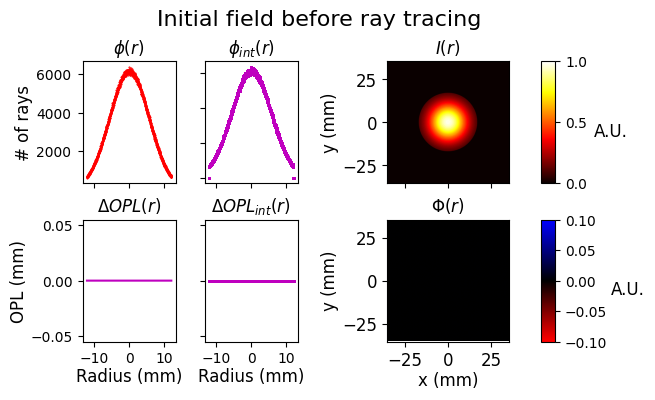

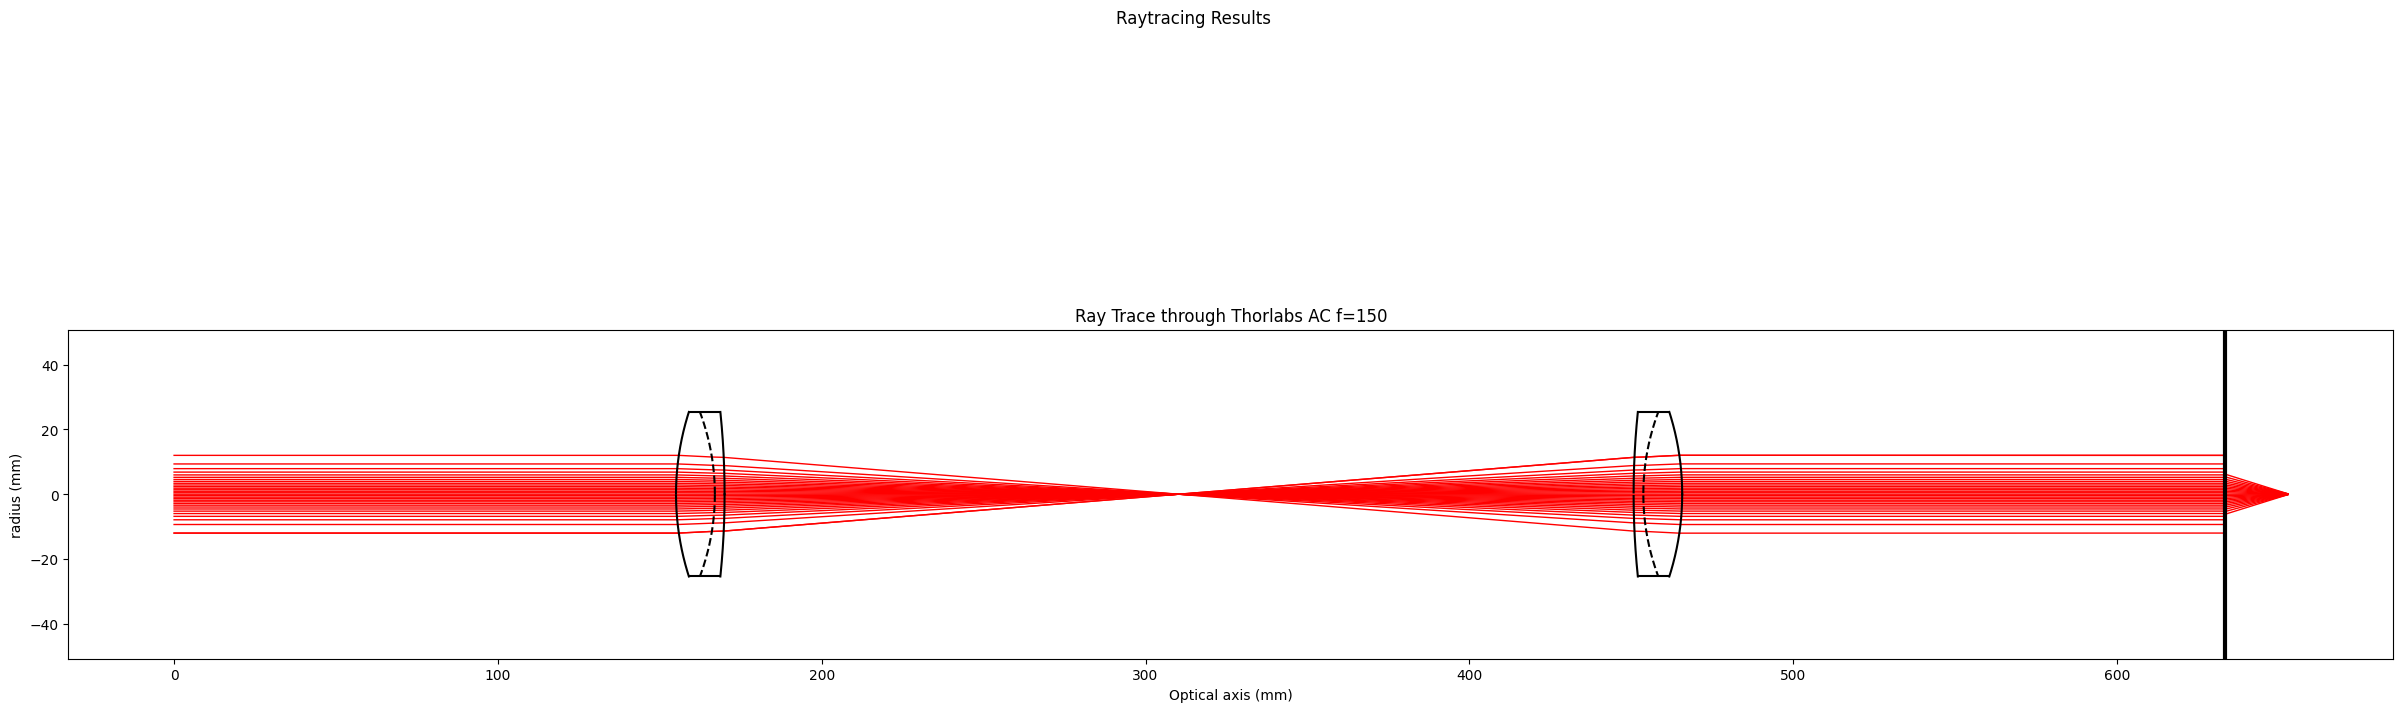

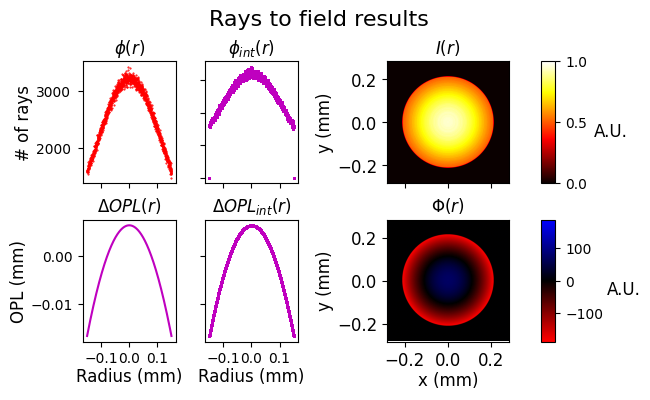

[########################################] | 100% Completed | 3.81 ss


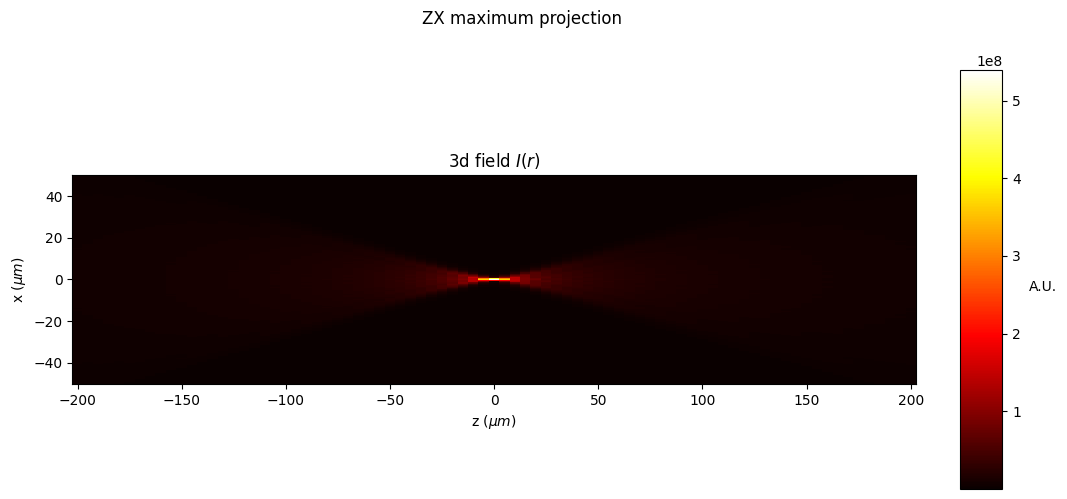

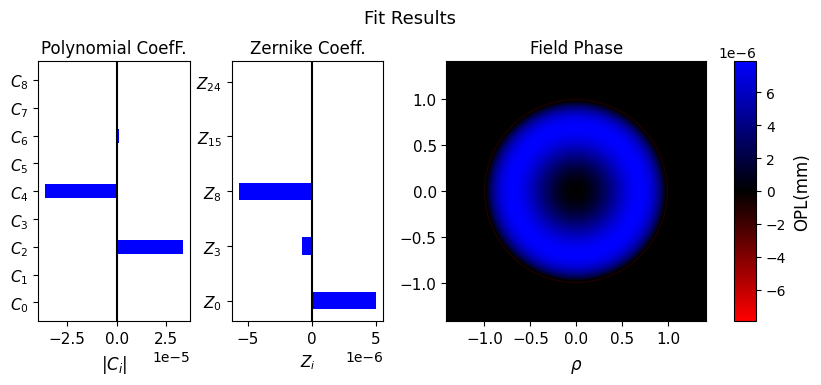

In [2]:
initial_rays = rt.create_rays(*rays_params.values())
n_rays = initial_rays.shape[1]

# Create field for initial ray distribution
field_i = rt.rays_to_field(mask_radius=radius_xy_i,
                           rays=initial_rays.copy(),
                           ko=2 * np.pi / wl,
                           amp_binning=n_xy,
                           amp_type=None,
                           phase_type="opld",
                           results="field",
                           plot_field=True,
                           title="Initial field before ray tracing",
                           save_path=None,
                           showfig=showfig)


plot_ray_distributions = False
if plot_ray_distributions:
    # Plot initial ray distribution
    hist, bin_edges = np.histogram(initial_rays[0, :, 0],
                                   bins=n_xy,
                                   density=False)
    plt.figure()
    plt.title('PDF of initial ray distribution')
    plt.plot(bin_edges[:-1], hist, '.')
    plt.xlabel('Radial position, mm')
    plt.ylabel('PDF')
    plt.show()

    # Plot final ray distribution
    nan_mask = np.logical_not(np.isnan(initial_rays[-1, :, 0]))
    max_radius = np.max(initial_rays[-1, :, 0][nan_mask])
    hist, bin_edges = np.histogram(initial_rays[-1, :, 0][nan_mask],
                                   bins=n_xy,
                                   density=False)
    plt.figure()
    plt.title('PDF of final ray distribution')
    plt.plot(bin_edges[:-1], hist, '.')
    plt.xlabel('Radial position, mm')
    plt.ylabel('Bin Counts')
    plt.show()

# Ray trace through lens
results = rt.raytrace_ot(optical_train=ot,
                         rays=initial_rays.copy(),
                         fit_plane="midpoint",
                         fit_method="opld",
                         return_rays="all",
                         plot_raytrace_results=False,
                         showfig=showfig,
                         save_path=None
                         )

rays = results["rays"]

# calculate rays to field z plane.
initial_field_z = rt.rays_to_field_plane(rays=rays,
                                         x_max=x.max(),
                                         padding=x_padding)

# ray trace to final plane.
rays = rt.intersect_plane(rays, zf=initial_field_z, ri_in=1.0, refract=False)
midpoint_fp = rt.ray_focal_plane(rays, ri=1.0, method="midpoint")

# plot results
rt.plot_rays(rays.copy(),
             n_rays_to_plot=31,
             optical_train=ot,
             title='Ray Trace through Thorlabs AC f=150',
             save_path=None,
             showfig=showfig)

# Create initial field to propagate
field_2d = rt.rays_to_field(mask_radius=radius_xy,
                            rays=rays.copy(),
                            ko=2 * np.pi / wl,
                            amp_binning=n_xy,
                            amp_type="flux",
                            phase_type="opld",
                            results="field",
                            plot_field=True,
                            title="Rays to field results",
                            save_path=None,
                            showfig=showfig)

# Define propagation coordinates
z_prop = (z + midpoint_fp) - initial_field_z

# Propgate initial field
field_3d = pt.get_3d_field(field_2d, z_prop, wl, dx, 1.00)

# Plot results
pt.plot_xz_projection(fields=[field_3d],
                      field_labels=["3d field"],
                      x_max=50,
                      grid_params=[focus_field_params],
                      fig_title="ZX maximum projection",
                      showfig=showfig,
                      save_path=None)

rt.plot_fit_summary(fit=results["opl_fit"]*-1,
                    showfig=showfig,
                    save_path=None)